<a href="https://colab.research.google.com/github/hpietukhin/churn/blob/master/churn_Pietukhin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install marimo pandas numpy matplotlib seaborn scikit-learn statsmodels xgboost

In [ ]:
import marimo as mo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    learning_curve,
)
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_curve,
    roc_auc_score,
)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# XGBoost import
from xgboost import XGBClassifier

# Set seed for reproducibility
np.random.seed(42)

# Set plot style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Bank Customer Churn Prediction (Enhanced)

This notebook implements a machine learning pipeline to predict customer churn
using multiple classification algorithms.

## Project Overview
- **Dataset**: Bank Customer Churn Dataset (10,000 customers)
- **Goal**: Predict whether a customer will leave the bank
- **Methods**: Random Forest, AdaBoost, XGBoost, SVM, Logistic Regression
- **Metrics**: Accuracy, Sensitivity, Specificity, Precision, F1-score, AUC, Gini

## Enhancements over Original
- **70/15/15 Train/Validation/Test split** (was 80/20 train/test)
- **XGBoost** with early stopping on validation set
- **SVM** with RBF kernel
- **Feature engineering**: balance_to_salary_ratio
- **VIF analysis** for multicollinearity detection
- **Learning curves** for bias/variance diagnosis

In [ ]:
# Load data (remove first column - customer_id)

data_bank = pd.read_csv("https://raw.githubusercontent.com/hpietukhin/churn/refs/heads/master/Bank%20Customer%20Churn%20Prediction.csv").iloc[
    :, 1:
]

mo.md(f"""
## 1. Data Loading

Loaded dataset with **{len(data_bank)}** rows and **{len(data_bank.columns)}** columns.

### Data Preview:
""")

_md()

In [ ]:
mo.ui.table(data_bank.head(10))

table()

In [ ]:
mo.md(f"""
### Data Structure:

**Columns**: {", ".join(data_bank.columns.tolist())}

**Data Types**:
```
{data_bank.dtypes.to_string()}
```

**Missing Values**: {data_bank.isnull().sum().sum()}

**Target Distribution**:
- Churn = 0 (stayed): {(data_bank["churn"] == 0).sum()} ({(data_bank["churn"] == 0).sum() / len(data_bank) * 100:.1f}%)
- Churn = 1 (left): {(data_bank["churn"] == 1).sum()} ({(data_bank["churn"] == 1).sum() / len(data_bank) * 100:.1f}%)
""")

_md()

In [ ]:
# Correlation matrix for numeric variables
num_data = data_bank.select_dtypes(include=[np.number])
cor_matrix = num_data.corr()

mo.md("""
## 2. Correlation Analysis

Examining correlations between numeric variables and the target (churn).
The three least correlated variables with churn are:
- tenure (length of membership)
- credit_card
- estimated_salary
""")

_md()

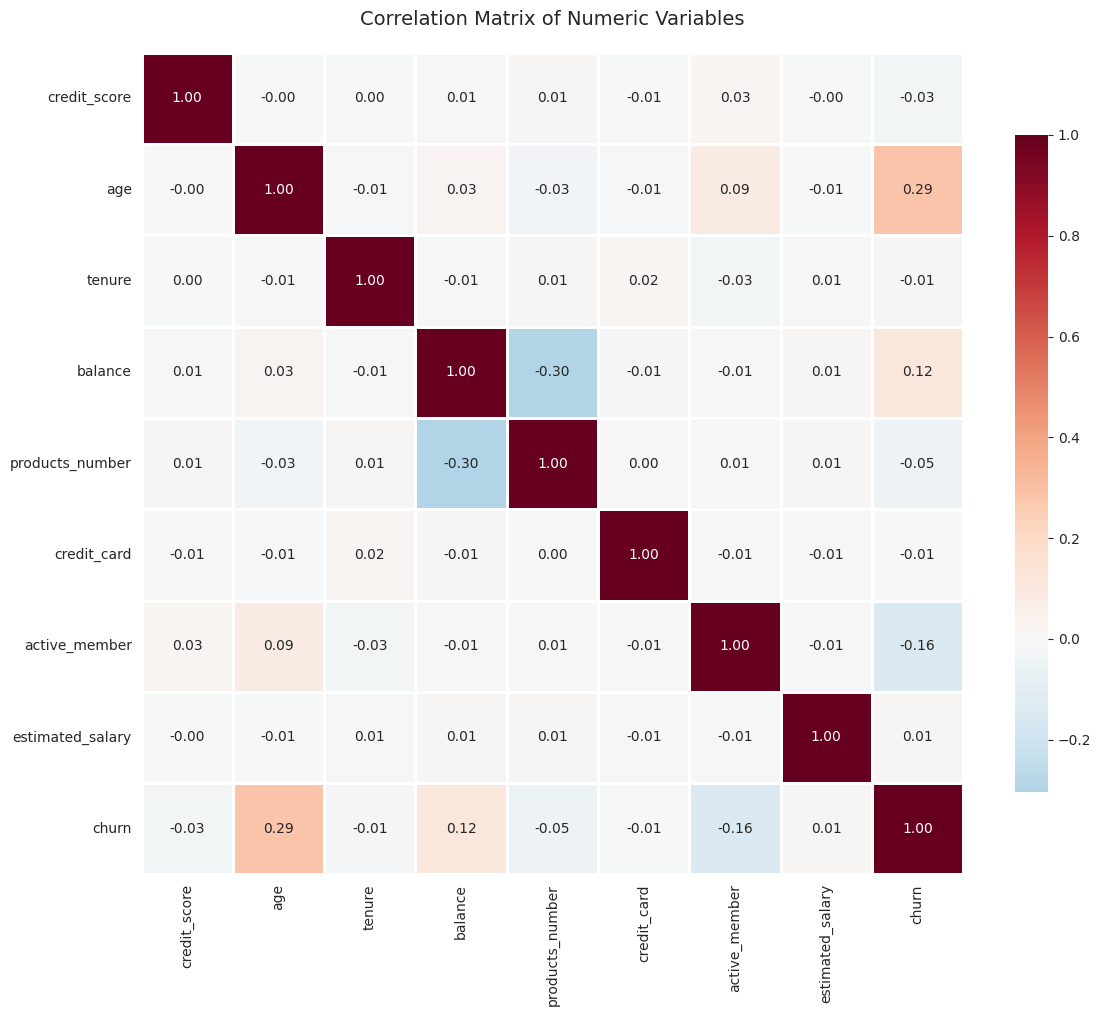

In [ ]:
# Plot correlation matrix
fig_corr, ax_corr = plt.subplots(figsize=(12, 10))
sns.heatmap(
    cor_matrix,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8},
    ax=ax_corr,
)
ax_corr.set_title(
    "Correlation Matrix of Numeric Variables", fontsize=14, pad=20
)
plt.tight_layout()

## 3. Data Visualization

Exploring the distribution of key variables.

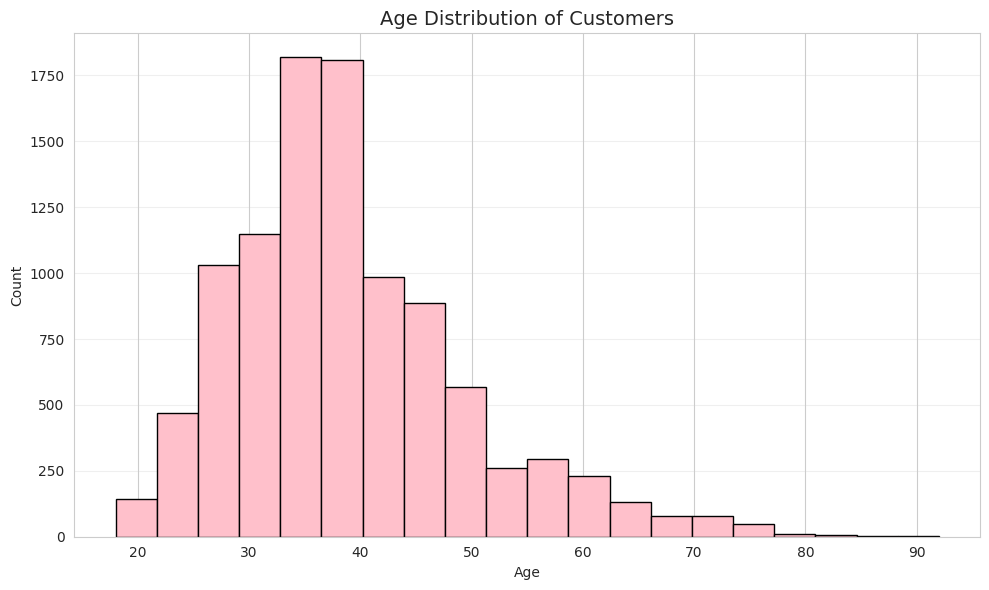

In [ ]:
# Age distribution
fig_age, ax_age = plt.subplots(figsize=(10, 6))
ax_age.hist(data_bank["age"], bins=20, color="pink", edgecolor="black")
ax_age.set_title("Age Distribution of Customers", fontsize=14)
ax_age.set_xlabel("Age")
ax_age.set_ylabel("Count")
ax_age.grid(axis="y", alpha=0.3)
plt.tight_layout()

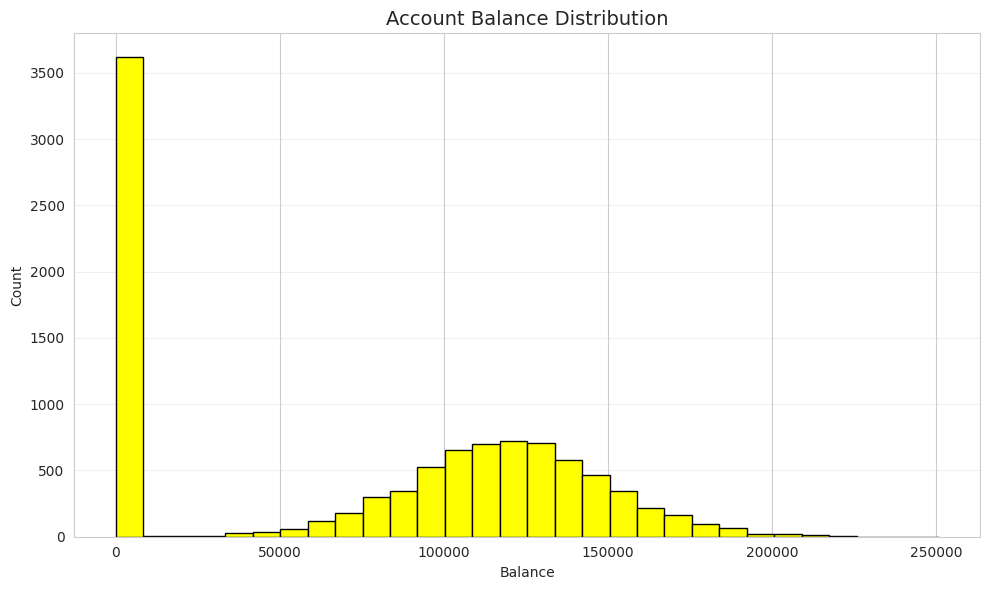

In [ ]:
# Balance distribution
fig_balance, ax_balance = plt.subplots(figsize=(10, 6))
ax_balance.hist(
    data_bank["balance"], bins=30, color="yellow", edgecolor="black"
)
ax_balance.set_title("Account Balance Distribution", fontsize=14)
ax_balance.set_xlabel("Balance")
ax_balance.set_ylabel("Count")
ax_balance.grid(axis="y", alpha=0.3)
plt.tight_layout()

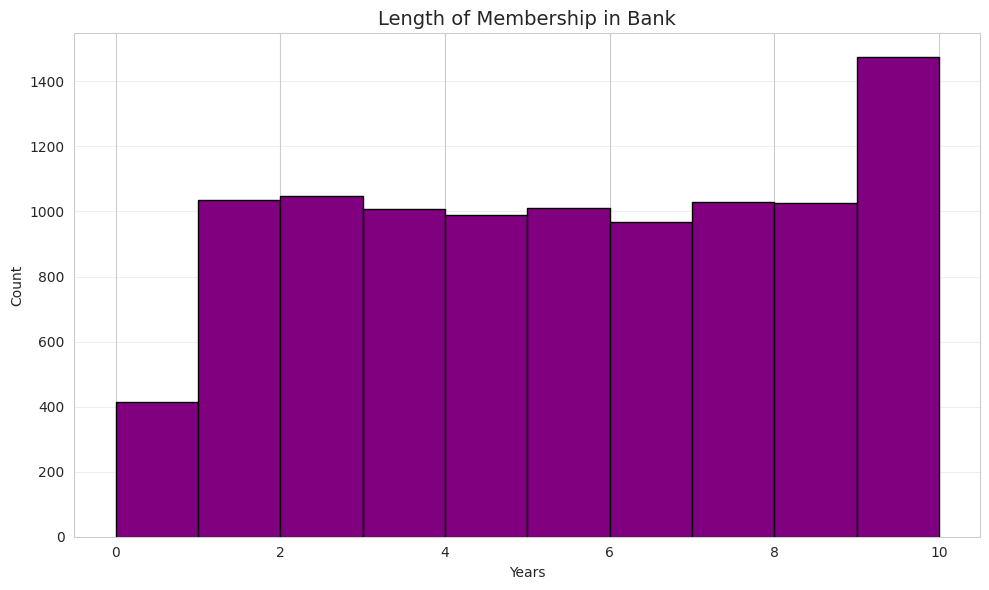

In [ ]:
# Tenure distribution
fig_tenure, ax_tenure = plt.subplots(figsize=(10, 6))
ax_tenure.hist(data_bank["tenure"], bins=10, color="purple", edgecolor="black")
ax_tenure.set_title("Length of Membership in Bank", fontsize=14)
ax_tenure.set_xlabel("Years")
ax_tenure.set_ylabel("Count")
ax_tenure.grid(axis="y", alpha=0.3)
plt.tight_layout()

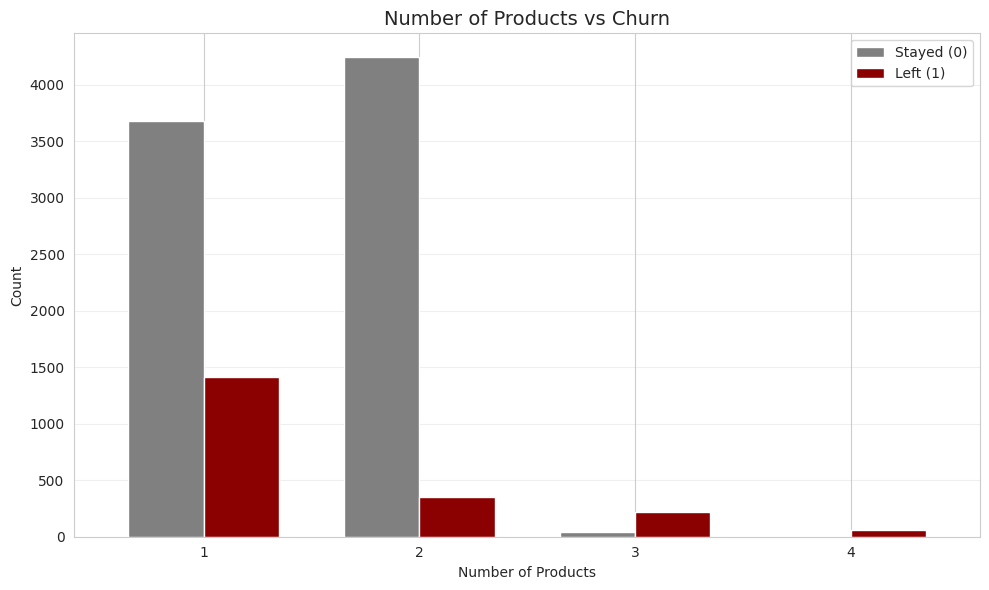

In [ ]:
# Products vs Churn
fig_products, ax_products = plt.subplots(figsize=(10, 6))
products_churn = pd.crosstab(data_bank["products_number"], data_bank["churn"])
products_churn.plot(
    kind="bar", ax=ax_products, color=["gray", "darkred"], width=0.7
)
ax_products.set_title("Number of Products vs Churn", fontsize=14)
ax_products.set_xlabel("Number of Products")
ax_products.set_ylabel("Count")
ax_products.set_xticklabels(ax_products.get_xticklabels(), rotation=0)
ax_products.legend(["Stayed (0)", "Left (1)"])
ax_products.grid(axis="y", alpha=0.3)
plt.tight_layout()

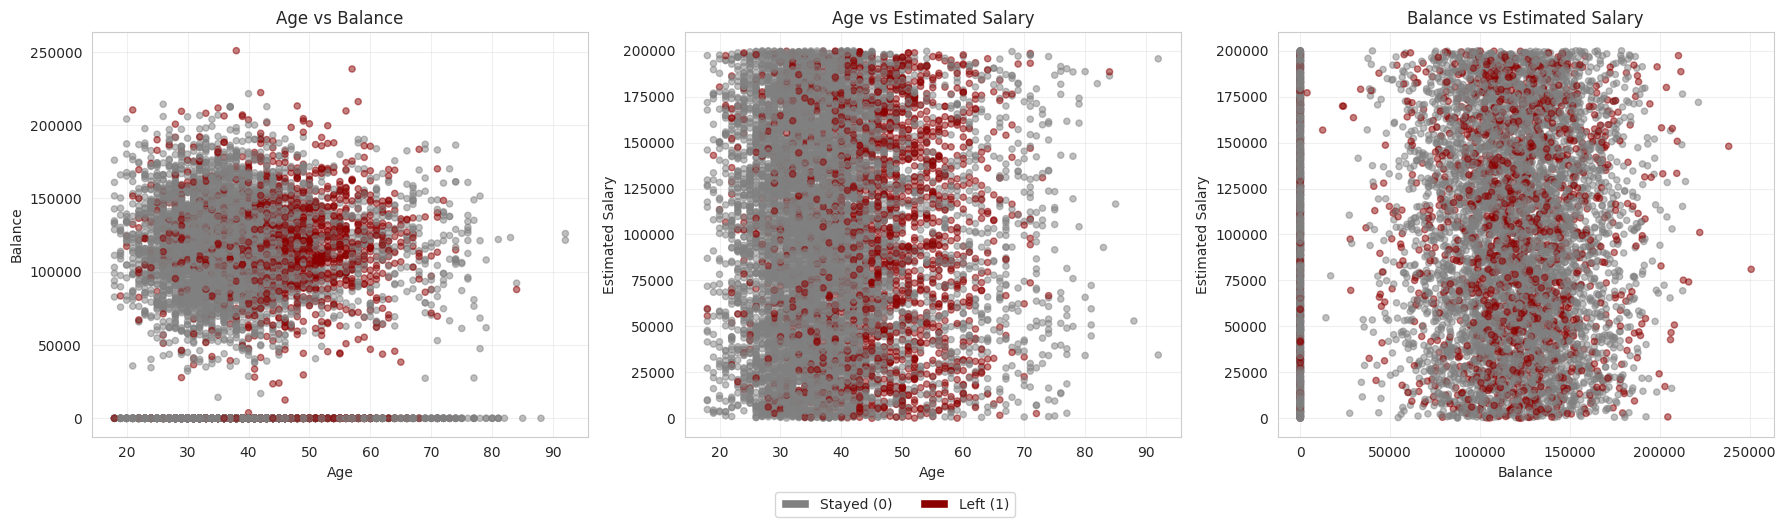

In [ ]:
# Scatter plot matrix: age, balance, salary
fig_scatter, axes_scatter = plt.subplots(1, 3, figsize=(18, 5))

# Age vs Balance
colors = ["gray" if c == 0 else "darkred" for c in data_bank["churn"]]
axes_scatter[0].scatter(
    data_bank["age"], data_bank["balance"], c=colors, alpha=0.5, s=20
)
axes_scatter[0].set_xlabel("Age")
axes_scatter[0].set_ylabel("Balance")
axes_scatter[0].set_title("Age vs Balance")
axes_scatter[0].grid(alpha=0.3)

# Age vs Salary
axes_scatter[1].scatter(
    data_bank["age"], data_bank["estimated_salary"], c=colors, alpha=0.5, s=20
)
axes_scatter[1].set_xlabel("Age")
axes_scatter[1].set_ylabel("Estimated Salary")
axes_scatter[1].set_title("Age vs Estimated Salary")
axes_scatter[1].grid(alpha=0.3)

# Balance vs Salary
axes_scatter[2].scatter(
    data_bank["balance"],
    data_bank["estimated_salary"],
    c=colors,
    alpha=0.5,
    s=20,
)
axes_scatter[2].set_xlabel("Balance")
axes_scatter[2].set_ylabel("Estimated Salary")
axes_scatter[2].set_title("Balance vs Estimated Salary")
axes_scatter[2].grid(alpha=0.3)

# Add legend
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor="gray", label="Stayed (0)"),
    Patch(facecolor="darkred", label="Left (1)"),
]
fig_scatter.legend(
    handles=legend_elements,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.02),
    ncol=2,
)

plt.tight_layout()

## 4. Feature Engineering

Creating new features that may improve model performance.

### New Feature: balance_to_salary_ratio
- Captures the relationship between account balance and income
- Customers with high balance relative to salary may have different churn behavior
- Formula: `balance / (estimated_salary + 1)` (add 1 to avoid division by zero)

In [ ]:
# Create new feature: balance_to_salary_ratio
data_bank["balance_to_salary_ratio"] = data_bank["balance"] / (
    data_bank["estimated_salary"] + 1
)

mo.md(f"""
`balance_to_salary_ratio`

- Min: {data_bank["balance_to_salary_ratio"].min():.4f}
- Max: {data_bank["balance_to_salary_ratio"].max():.4f}
- Mean: {data_bank["balance_to_salary_ratio"].mean():.4f}
- Median: {data_bank["balance_to_salary_ratio"].median():.4f}

This feature captures how much of their salary equivalent a customer keeps in the bank.
""")

_md()

Data preporcessing

In [ ]:
# Convert categorical variables to category type
data_prepared = data_bank.copy()
data_prepared["country"] = pd.Categorical(data_prepared["country"])
data_prepared["gender"] = pd.Categorical(data_prepared["gender"])
data_prepared["credit_card"] = data_prepared["credit_card"].astype("int")
data_prepared["active_member"] = data_prepared["active_member"].astype("int")
data_prepared["churn"] = data_prepared["churn"].astype(
    "int"
)  # Ensure int for sklearn

# One-hot encode categorical variables
data_encoded = pd.get_dummies(
    data_prepared, columns=["country", "gender"], drop_first=True
)

# Prepare features and target
X = data_encoded.drop("churn", axis=1)
y = data_encoded["churn"]

# Step 1: Split into train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=123, stratify=y
)

# Step 2: Split temp into validation (15%) and test (15%)
# 50% of 30% = 15% each
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=123, stratify=y_temp
)

# Feature Scaling
scaler = StandardScaler()
numerical_features = [
    "credit_score",
    "age",
    "tenure",
    "balance",
    "estimated_salary",
    "products_number",
    "balance_to_salary_ratio",
]

# Create scaled versions for models that need it (Logistic Regression, SVM)
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(
    X_train[numerical_features]
)
X_val_scaled[numerical_features] = scaler.transform(X_val[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(
    X_test[numerical_features]
)

In [ ]:
mo.md(f"""
### Data Split Summary (70/15/15):

| Set | Samples | Churn=0 | Churn=1 | Churn Rate |
|-----|---------|---------|---------|------------|
| Train | {len(X_train)} | {(y_train == 0).sum()} | {(y_train == 1).sum()} | {(y_train == 1).sum() / len(y_train) * 100:.1f}% |
| Validation | {len(X_val)} | {(y_val == 0).sum()} | {(y_val == 1).sum()} | {(y_val == 1).sum() / len(y_val) * 100:.1f}% |
| Test | {len(X_test)} | {(y_test == 0).sum()} | {(y_test == 1).sum()} | {(y_test == 1).sum() / len(y_test) * 100:.1f}% |

**Features**: {len(X_train.columns)} (including new `balance_to_salary_ratio`)

Stratified splitting ensures consistent churn rates across all sets.
""")

Set,Samples,Churn=0,Churn=1,Churn Rate
Train,7000,5574,1426,20.4%
Validation,1500,1194,306,20.4%
Test,1500,1195,305,20.3%


## 6. VIF Analysis (Variance Inflation Factor)

VIF detects **multicollinearity** - when predictor variables are highly correlated with each other.

### Why it matters:
- High VIF (>5-10) means a feature is linearly predictable from others
- Makes Logistic Regression coefficients unstable and hard to interpret
- Tree-based models (Random Forest, XGBoost) are not affected

### Interpretation:
- **VIF < 5**: Acceptable
- **VIF 5-10**: Moderate multicollinearity, investigate
- **VIF > 10**: Severe — consider removing or combining features

In [ ]:
# Calculate VIF for numerical features
from statsmodels.tools.tools import add_constant

X_vif = X_train[numerical_features].copy()

# Handle any infinite or NaN values
X_vif = X_vif.replace([np.inf, -np.inf], np.nan).dropna()

# Add constant for proper VIF calculation
X_vif_with_const = add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data["Feature"] = numerical_features
# Calculate VIF starting from index 1 (skip the constant at index 0)
vif_data["VIF"] = [
    variance_inflation_factor(X_vif_with_const.values, i + 1)
    for i in range(len(numerical_features))
]
vif_data = vif_data.sort_values("VIF", ascending=False).reset_index(drop=True)


# Add interpretation
def vif_interpretation(vif):
    if vif < 5:
        return "OK"
    elif vif < 10:
        return "Moderate"
    else:
        return "High"


vif_data["Status"] = vif_data["VIF"].apply(vif_interpretation)

mo.md(f"""
### VIF Results for Numerical Features:

| Feature | VIF | Status |
|---------|-----|--------|
{"".join([f"| {row['Feature']} | {row['VIF']:.2f} | {row['Status']} |" + chr(10) for _, row in vif_data.iterrows()])}

**Note**: VIF calculation includes intercept term for accurate multicollinearity detection.
High VIF (>10) indicates the feature is highly predictable from other features.
""")

Feature,VIF,Status
products_number,1.10,OK
balance,1.10,OK
balance_to_salary_ratio,1.00,OK
estimated_salary,1.00,OK
age,1.00,OK
tenure,1.00,OK
credit_score,1.00,OK


## 7. Model Training

Training 5 classification models:
1. **Random Forest** — bagging ensemble of decision trees
2. **AdaBoost** — boosting with adaptive sample weights
3. **XGBoost** — gradient boosting with regularization (uses validation set for early stopping)
4. **SVM** — support vector machine with RBF kernel
5. **Logistic Regression** — linear baseline model

All models use `class_weight='balanced'` (or equivalent) to handle class imbalance.

### 7.1 Random Forest

Random Forest uses **bagging**: trains many decision trees on bootstrap samples
and combines predictions via majority voting. Reduces variance without increasing bias.

**Regularization applied**: max_depth=10, min_samples_leaf=20, min_samples_split=50
to prevent overfitting (which caused 100% training accuracy in initial runs).

In [ ]:
# Random Forest with regularization to prevent overfitting
rf_model = RandomForestClassifier(
    random_state=123,
    n_estimators=100,
    max_depth=10,  # Limit tree depth
    min_samples_leaf=20,  # Require at least 20 samples per leaf
    min_samples_split=50,  # Require at least 50 samples to split
    class_weight="balanced",
)
rf_model.fit(X_train, y_train)

# Predictions
rf_pred_train = rf_model.predict(X_train)
rf_pred_val = rf_model.predict(X_val)
rf_pred_test = rf_model.predict(X_test)
rf_prob_test = rf_model.predict_proba(X_test)[:, 1]

In [ ]:
cm_rf_train = confusion_matrix(y_train, rf_pred_train)
cm_rf_val = confusion_matrix(y_val, rf_pred_val)
cm_rf_test = confusion_matrix(y_test, rf_pred_test)

mo.md(f"""
**Random Forest Confusion Matrices**

| Set | TN | FP | FN | TP |
|-----|----|----|----|----|
| Train | {cm_rf_train[0, 0]} | {cm_rf_train[0, 1]} | {cm_rf_train[1, 0]} | {cm_rf_train[1, 1]} |
| Val | {cm_rf_val[0, 0]} | {cm_rf_val[0, 1]} | {cm_rf_val[1, 0]} | {cm_rf_val[1, 1]} |
| Test | {cm_rf_test[0, 0]} | {cm_rf_test[0, 1]} | {cm_rf_test[1, 0]} | {cm_rf_test[1, 1]} |
""")

Set,TN,FP,FN,TP
Train,4678,896,278,1148
Val,957,237,79,227
Test,989,206,91,214


### 7.2 AdaBoost

AdaBoost is a **boosting** algorithm that trains weak learners sequentially.
After each iteration, misclassified samples get higher weights, forcing the next
learner to focus on hard cases.

**Key difference from XGBoost**: AdaBoost adjusts sample weights; XGBoost uses gradient descent
on a loss function with regularization.

In [ ]:
# AdaBoost
ada_model = AdaBoostClassifier(random_state=123, n_estimators=100)
ada_model.fit(X_train, y_train)

# Predictions
ada_pred_train = ada_model.predict(X_train)
ada_pred_val = ada_model.predict(X_val)
ada_pred_test = ada_model.predict(X_test)
ada_prob_test = ada_model.predict_proba(X_test)[:, 1]

In [ ]:
cm_ada_train = confusion_matrix(y_train, ada_pred_train)
cm_ada_val = confusion_matrix(y_val, ada_pred_val)
cm_ada_test = confusion_matrix(y_test, ada_pred_test)

mo.md(f"""
**AdaBoost Confusion Matrices**

| Set | TN | FP | FN | TP |
|-----|----|----|----|----|
| Train | {cm_ada_train[0, 0]} | {cm_ada_train[0, 1]} | {cm_ada_train[1, 0]} | {cm_ada_train[1, 1]} |
| Val | {cm_ada_val[0, 0]} | {cm_ada_val[0, 1]} | {cm_ada_val[1, 0]} | {cm_ada_val[1, 1]} |
| Test | {cm_ada_test[0, 0]} | {cm_ada_test[0, 1]} | {cm_ada_test[1, 0]} | {cm_ada_test[1, 1]} |
""")

Set,TN,FP,FN,TP
Train,5366,208,795,631
Val,1146,48,154,152
Test,1132,63,172,133


### 7.3 XGBoost

XGBoost (eXtreme Gradient Boosting) is a **gradient boosting** algorithm with several advantages:

| Feature | AdaBoost | XGBoost |
|---------|----------|---------|
| Weight update | Sample weights | Gradient descent on loss |
| Regularization | None | L1 and L2 penalties |
| Missing values | Requires imputation | Handles natively |
| Early stopping | Not built-in | Built-in with validation set |
| Speed | Slower | Optimized with parallelization |

**Why XGBoost often wins**: Regularization prevents overfitting, and early stopping
finds optimal number of trees automatically.

We use the **validation set** to determine when to stop training (early stopping).

In [ ]:
# XGBoost with early stopping
# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight,
    eval_metric="auc",
    random_state=123,
    n_jobs=-1,
    early_stopping_rounds=30,
)

# Fit with validation set for early stopping
xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=False,
)

# Predictions
xgb_pred_train = xgb_model.predict(X_train)
xgb_pred_val = xgb_model.predict(X_val)
xgb_pred_test = xgb_model.predict(X_test)
xgb_prob_test = xgb_model.predict_proba(X_test)[:, 1]

best_iteration = xgb_model.best_iteration

In [ ]:
cm_xgb_train = confusion_matrix(y_train, xgb_pred_train)
cm_xgb_val = confusion_matrix(y_val, xgb_pred_val)
cm_xgb_test = confusion_matrix(y_test, xgb_pred_test)

mo.md(f"""
**XGBoost Confusion Matrices**

Early stopping triggered at iteration **{best_iteration}** (out of max 500).
This prevents overfitting by stopping when validation performance stops improving.

| Set | TN | FP | FN | TP |
|-----|----|----|----|----|
| Train | {cm_xgb_train[0, 0]} | {cm_xgb_train[0, 1]} | {cm_xgb_train[1, 0]} | {cm_xgb_train[1, 1]} |
| Val | {cm_xgb_val[0, 0]} | {cm_xgb_val[0, 1]} | {cm_xgb_val[1, 0]} | {cm_xgb_val[1, 1]} |
| Test | {cm_xgb_test[0, 0]} | {cm_xgb_test[0, 1]} | {cm_xgb_test[1, 0]} | {cm_xgb_test[1, 1]} |
""")

Set,TN,FP,FN,TP
Train,4606,968,285,1141
Val,947,247,74,232
Test,989,206,68,237


### 7.4 SVM (Support Vector Machine)

SVM with RBF kernel finds a nonlinear decision boundary by mapping features
to a higher-dimensional space.

**Important**: SVM requires **scaled features** — we use the StandardScaler-transformed data.

**Note**: SVM doesn't provide feature importance directly (unlike tree-based models).

In [ ]:
# SVM with RBF kernel (requires scaled features)
svm_model = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    class_weight="balanced",
    probability=True,  # Needed for predict_proba
    random_state=123,
)
svm_model.fit(X_train_scaled, y_train)

# Predictions
svm_pred_train = svm_model.predict(X_train_scaled)
svm_pred_val = svm_model.predict(X_val_scaled)
svm_pred_test = svm_model.predict(X_test_scaled)
svm_prob_test = svm_model.predict_proba(X_test_scaled)[:, 1]

In [ ]:
cm_svm_train = confusion_matrix(y_train, svm_pred_train)
cm_svm_val = confusion_matrix(y_val, svm_pred_val)
cm_svm_test = confusion_matrix(y_test, svm_pred_test)

mo.md(f"""
**SVM Confusion Matrices**

| Set | TN | FP | FN | TP |
|-----|----|----|----|----|
| Train | {cm_svm_train[0, 0]} | {cm_svm_train[0, 1]} | {cm_svm_train[1, 0]} | {cm_svm_train[1, 1]} |
| Val | {cm_svm_val[0, 0]} | {cm_svm_val[0, 1]} | {cm_svm_val[1, 0]} | {cm_svm_val[1, 1]} |
| Test | {cm_svm_test[0, 0]} | {cm_svm_test[0, 1]} | {cm_svm_test[1, 0]} | {cm_svm_test[1, 1]} |
""")

Set,TN,FP,FN,TP
Train,4550,1024,286,1140
Val,945,249,61,245
Test,954,241,79,226


### 7.5 Logistic Regression

Linear baseline model. Uses scaled features for stable coefficient estimation.

In [ ]:
# Logistic Regression (requires scaled features)
lr_model = LogisticRegression(
    random_state=123,
    max_iter=1000,
    class_weight="balanced",
)
lr_model.fit(X_train_scaled, y_train)

# Predictions
lr_pred_train = lr_model.predict(X_train_scaled)
lr_pred_val = lr_model.predict(X_val_scaled)
lr_pred_test = lr_model.predict(X_test_scaled)
lr_prob_test = lr_model.predict_proba(X_test_scaled)[:, 1]

In [ ]:
cm_lr_train = confusion_matrix(y_train, lr_pred_train)
cm_lr_val = confusion_matrix(y_val, lr_pred_val)
cm_lr_test = confusion_matrix(y_test, lr_pred_test)

mo.md(f"""
**Logistic Regression Confusion Matrices**

| Set | TN | FP | FN | TP |
|-----|----|----|----|----|
| Train | {cm_lr_train[0, 0]} | {cm_lr_train[0, 1]} | {cm_lr_train[1, 0]} | {cm_lr_train[1, 1]} |
| Val | {cm_lr_val[0, 0]} | {cm_lr_val[0, 1]} | {cm_lr_val[1, 0]} | {cm_lr_val[1, 1]} |
| Test | {cm_lr_test[0, 0]} | {cm_lr_test[0, 1]} | {cm_lr_test[1, 0]} | {cm_lr_test[1, 1]} |
""")

Set,TN,FP,FN,TP
Train,4042,1532,428,998
Val,835,359,96,210
Test,864,331,102,203


## 8. Learning Curves (Bias vs Variance Diagnosis)

Learning curves show how model performance changes with training set size.

### How to interpret:
- **High Bias (underfitting)**: Both train and validation scores are low and close together.
  Model is too simple, needs more features or complexity.

- **High Variance (overfitting)**: Train score is high but validation score is much lower.
  Model memorizes training data, needs regularization or more data.

- **Good Fit**: Both scores converge at a high value as training size increases.

We plot learning curves for **Random Forest** and **XGBoost** to compare their behavior.

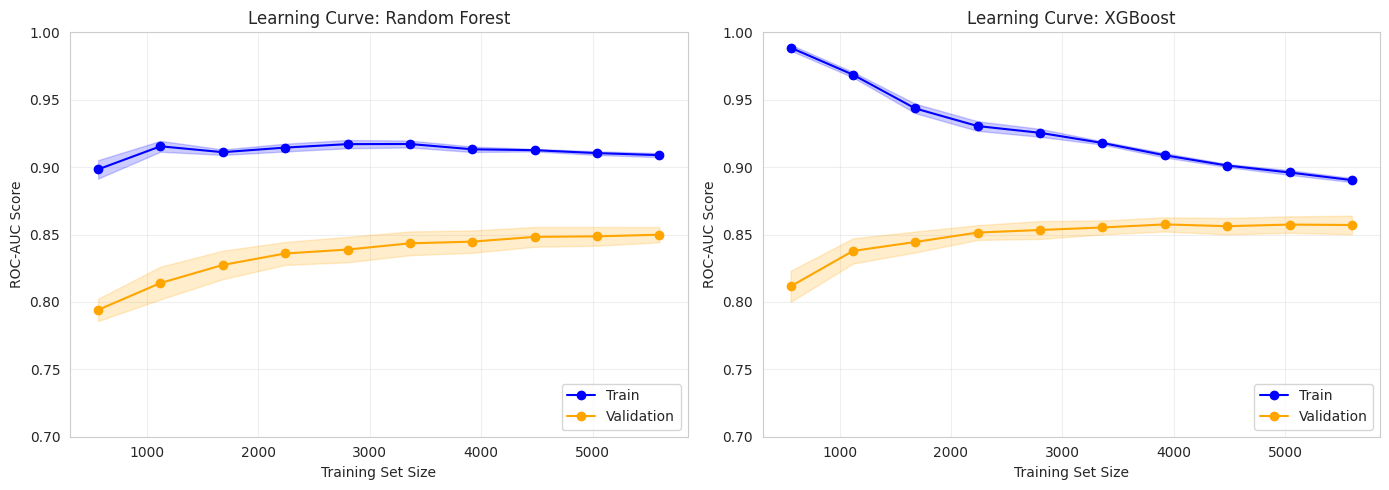

In [ ]:
# Learning curves for Random Forest and XGBoost
fig_lc, axes_lc = plt.subplots(1, 2, figsize=(14, 5))

cv_lc = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
train_sizes = np.linspace(0.1, 1.0, 10)

# Random Forest learning curve
train_sizes_rf, train_scores_rf, val_scores_rf = learning_curve(
    rf_model,
    X_train,
    y_train,
    train_sizes=train_sizes,
    cv=cv_lc,
    scoring="roc_auc",
    n_jobs=-1,
)

# XGBoost learning curve (create a fresh model without early stopping for fair comparison)
xgb_lc_model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=123,
    n_jobs=-1,
)

train_sizes_xgb, train_scores_xgb, val_scores_xgb = learning_curve(
    xgb_lc_model,
    X_train,
    y_train,
    train_sizes=train_sizes,
    cv=cv_lc,
    scoring="roc_auc",
    n_jobs=-1,
)

# Plot Random Forest
axes_lc[0].fill_between(
    train_sizes_rf,
    train_scores_rf.mean(axis=1) - train_scores_rf.std(axis=1),
    train_scores_rf.mean(axis=1) + train_scores_rf.std(axis=1),
    alpha=0.2,
    color="blue",
)
axes_lc[0].fill_between(
    train_sizes_rf,
    val_scores_rf.mean(axis=1) - val_scores_rf.std(axis=1),
    val_scores_rf.mean(axis=1) + val_scores_rf.std(axis=1),
    alpha=0.2,
    color="orange",
)
axes_lc[0].plot(
    train_sizes_rf,
    train_scores_rf.mean(axis=1),
    "o-",
    color="blue",
    label="Train",
)
axes_lc[0].plot(
    train_sizes_rf,
    val_scores_rf.mean(axis=1),
    "o-",
    color="orange",
    label="Validation",
)
axes_lc[0].set_xlabel("Training Set Size")
axes_lc[0].set_ylabel("ROC-AUC Score")
axes_lc[0].set_title("Learning Curve: Random Forest")
axes_lc[0].legend(loc="lower right")
axes_lc[0].grid(alpha=0.3)
axes_lc[0].set_ylim([0.7, 1.0])

# Plot XGBoost
axes_lc[1].fill_between(
    train_sizes_xgb,
    train_scores_xgb.mean(axis=1) - train_scores_xgb.std(axis=1),
    train_scores_xgb.mean(axis=1) + train_scores_xgb.std(axis=1),
    alpha=0.2,
    color="blue",
)
axes_lc[1].fill_between(
    train_sizes_xgb,
    val_scores_xgb.mean(axis=1) - val_scores_xgb.std(axis=1),
    val_scores_xgb.mean(axis=1) + val_scores_xgb.std(axis=1),
    alpha=0.2,
    color="orange",
)
axes_lc[1].plot(
    train_sizes_xgb,
    train_scores_xgb.mean(axis=1),
    "o-",
    color="blue",
    label="Train",
)
axes_lc[1].plot(
    train_sizes_xgb,
    val_scores_xgb.mean(axis=1),
    "o-",
    color="orange",
    label="Validation",
)
axes_lc[1].set_xlabel("Training Set Size")
axes_lc[1].set_ylabel("ROC-AUC Score")
axes_lc[1].set_title("Learning Curve: XGBoost")
axes_lc[1].legend(loc="lower right")
axes_lc[1].grid(alpha=0.3)
axes_lc[1].set_ylim([0.7, 1.0])

plt.tight_layout()

In [ ]:
# Interpret learning curves
rf_gap = train_scores_rf.mean(axis=1)[-1] - val_scores_rf.mean(axis=1)[-1]
xgb_gap = train_scores_xgb.mean(axis=1)[-1] - val_scores_xgb.mean(axis=1)[-1]

rf_final_val = val_scores_rf.mean(axis=1)[-1]
xgb_final_val = val_scores_xgb.mean(axis=1)[-1]

mo.md(f"""
### Learning Curve Analysis

| Model | Final Train AUC | Final Val AUC | Gap (Train - Val) | Diagnosis |
|-------|-----------------|---------------|-------------------|-----------|
| Random Forest | {train_scores_rf.mean(axis=1)[-1]:.3f} | {rf_final_val:.3f} | {rf_gap:.3f} | {"High variance" if rf_gap > 0.05 else "OK"} |
| XGBoost | {train_scores_xgb.mean(axis=1)[-1]:.3f} | {xgb_final_val:.3f} | {xgb_gap:.3f} | {"High variance" if xgb_gap > 0.05 else "OK"} |

**Interpretation**:
- A large gap (>0.05) between train and validation indicates **overfitting** (high variance)
- If both curves are low and flat, the model has **high bias** (underfitting)
- Converging curves at high values indicate a **good fit**

The shaded regions show +/- 1 standard deviation across CV folds.
""")

Model,Final Train AUC,Final Val AUC,Gap (Train - Val),Diagnosis
Random Forest,0.909,0.850,0.059,High variance
XGBoost,0.890,0.857,0.033,OK


## 9. Feature Importance Analysis

Comparing which features matter most to Random Forest vs XGBoost.

**Note**: SVM and Logistic Regression don't provide direct feature importance
(though LR coefficients can be interpreted with caution).

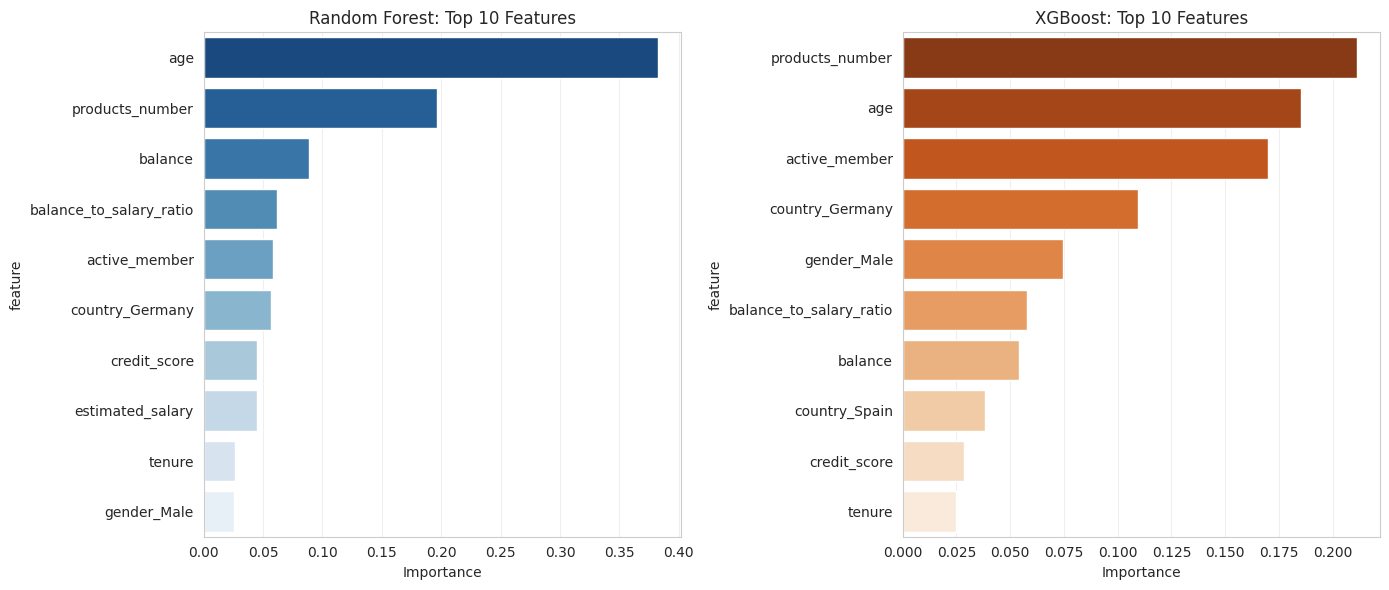

In [ ]:
# Feature importance comparison
fig_imp, axes_imp = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest importance
rf_importance = pd.DataFrame(
    {"feature": X_train.columns, "importance": rf_model.feature_importances_}
).sort_values("importance", ascending=False)

# XGBoost importance
xgb_importance = pd.DataFrame(
    {"feature": X_train.columns, "importance": xgb_model.feature_importances_}
).sort_values("importance", ascending=False)

# Plot RF
sns.barplot(
    data=rf_importance.head(10),
    x="importance",
    y="feature",
    hue="feature",
    palette="Blues_r",
    legend=False,
    ax=axes_imp[0],
)
axes_imp[0].set_title("Random Forest: Top 10 Features", fontsize=12)
axes_imp[0].set_xlabel("Importance")
axes_imp[0].grid(axis="x", alpha=0.3)

# Plot XGBoost
sns.barplot(
    data=xgb_importance.head(10),
    x="importance",
    y="feature",
    hue="feature",
    palette="Oranges_r",
    legend=False,
    ax=axes_imp[1],
)
axes_imp[1].set_title("XGBoost: Top 10 Features", fontsize=12)
axes_imp[1].set_xlabel("Importance")
axes_imp[1].grid(axis="x", alpha=0.3)

plt.tight_layout()

In [ ]:
mo.md(f"""
### Top 5 Features by Model

| Rank | Random Forest | XGBoost |
|------|---------------|---------|
| 1 | {rf_importance.iloc[0]["feature"]} ({rf_importance.iloc[0]["importance"]:.3f}) | {xgb_importance.iloc[0]["feature"]} ({xgb_importance.iloc[0]["importance"]:.3f}) |
| 2 | {rf_importance.iloc[1]["feature"]} ({rf_importance.iloc[1]["importance"]:.3f}) | {xgb_importance.iloc[1]["feature"]} ({xgb_importance.iloc[1]["importance"]:.3f}) |
| 3 | {rf_importance.iloc[2]["feature"]} ({rf_importance.iloc[2]["importance"]:.3f}) | {xgb_importance.iloc[2]["feature"]} ({xgb_importance.iloc[2]["importance"]:.3f}) |
| 4 | {rf_importance.iloc[3]["feature"]} ({rf_importance.iloc[3]["importance"]:.3f}) | {xgb_importance.iloc[3]["feature"]} ({xgb_importance.iloc[3]["importance"]:.3f}) |
| 5 | {rf_importance.iloc[4]["feature"]} ({rf_importance.iloc[4]["importance"]:.3f}) | {xgb_importance.iloc[4]["feature"]} ({xgb_importance.iloc[4]["importance"]:.3f}) |

""")

Rank,Random Forest,XGBoost
1,age (0.383),products_number (0.211)
2,products_number (0.196),age (0.185)
3,balance (0.089),active_member (0.170)
4,balance_to_salary_ratio (0.062),country_Germany (0.110)
5,active_member (0.058),gender_Male (0.074)


## 10. Model Evaluation Metrics

Calculating comprehensive metrics on the **test set** (final evaluation).

### Metrics:
- **Accuracy**: Overall correct predictions
- **Sensitivity (Recall)**: Correctly identified churners (TP / (TP + FN))
- **Specificity**: Correctly identified non-churners (TN / (TN + FP))
- **Precision**: Accuracy of positive predictions (TP / (TP + FP))
- **F1-Score**: Harmonic mean of precision and recall
- **AUC**: Area under ROC curve
- **Gini**: 2 * AUC - 1

In [ ]:
# Calculate metrics for all models
def calc_metrics(y_true, y_pred, y_prob, cm):
    auc = roc_auc_score(y_true, y_prob)
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Sensitivity": recall_score(y_true, y_pred, pos_label=1),
        "Specificity": cm[0, 0] / (cm[0, 0] + cm[0, 1]),
        "Precision": precision_score(y_true, y_pred, pos_label=1),
        "F1-Score": f1_score(y_true, y_pred, pos_label=1),
        "AUC": auc,
        "Gini": 2 * auc - 1,
    }


metrics_rf = calc_metrics(y_test, rf_pred_test, rf_prob_test, cm_rf_test)
metrics_ada = calc_metrics(y_test, ada_pred_test, ada_prob_test, cm_ada_test)
metrics_xgb = calc_metrics(y_test, xgb_pred_test, xgb_prob_test, cm_xgb_test)
metrics_svm = calc_metrics(y_test, svm_pred_test, svm_prob_test, cm_svm_test)
metrics_lr = calc_metrics(y_test, lr_pred_test, lr_prob_test, cm_lr_test)

# Create comparison table
metrics_df = pd.DataFrame(
    {
        "Random Forest": metrics_rf,
        "AdaBoost": metrics_ada,
        "XGBoost": metrics_xgb,
        "SVM": metrics_svm,
        "Logistic Reg": metrics_lr,
    }
).round(4)

metrics_df

,Random Forest,AdaBoost,XGBoost,SVM,Logistic Reg
Accuracy,0.8020,0.8433,0.8173,0.7867,0.7113
Sensitivity,0.7016,0.4361,0.7770,0.7410,0.6656
Specificity,0.8276,0.9473,0.8276,0.7983,0.7230
Precision,0.5095,0.6786,0.5350,0.4839,0.3801
F1-Score,0.5903,0.5309,0.6337,0.5855,0.4839
AUC,0.8487,0.8521,0.8743,0.8545,0.7510
Gini,0.6975,0.7042,0.7486,0.7091,0.5021


In [ ]:
# Find best model for each metric
best_models = metrics_df.idxmax(axis=1)

mo.md(f"""
### Best Model per Metric (Test Set)

| Metric | Best Model | Value |
|--------|------------|-------|
| Accuracy | {best_models["Accuracy"]} | {metrics_df.loc["Accuracy", best_models["Accuracy"]]:.4f} |
| Sensitivity | {best_models["Sensitivity"]} | {metrics_df.loc["Sensitivity", best_models["Sensitivity"]]:.4f} |
| Specificity | {best_models["Specificity"]} | {metrics_df.loc["Specificity", best_models["Specificity"]]:.4f} |
| F1-Score | {best_models["F1-Score"]} | {metrics_df.loc["F1-Score", best_models["F1-Score"]]:.4f} |
| AUC | {best_models["AUC"]} | {metrics_df.loc["AUC", best_models["AUC"]]:.4f} |

""")

Metric,Best Model,Value
Accuracy,AdaBoost,0.8433
Sensitivity,XGBoost,0.7770
Specificity,AdaBoost,0.9473
F1-Score,XGBoost,0.6337
AUC,XGBoost,0.8743


## 11. ROC Curves

Comparing all models using ROC curves on the test set.

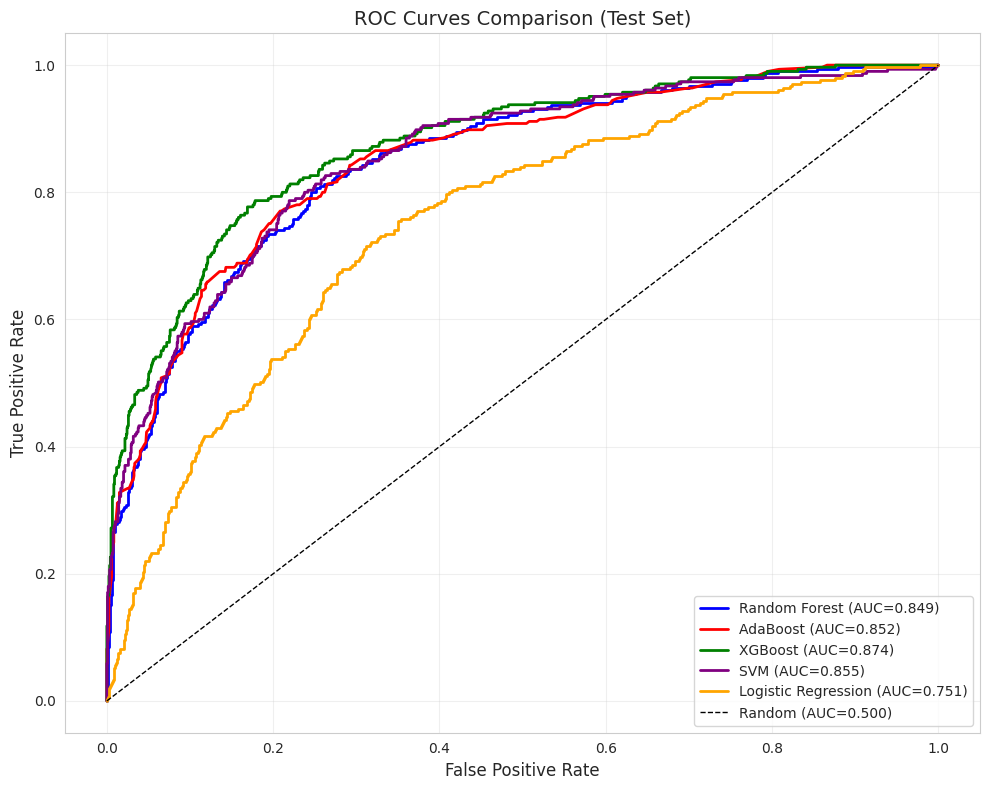

In [ ]:
# ROC curves for all models
fig_roc, ax_roc = plt.subplots(figsize=(10, 8))

models_roc = {
    "Random Forest": rf_prob_test,
    "AdaBoost": ada_prob_test,
    "XGBoost": xgb_prob_test,
    "SVM": svm_prob_test,
    "Logistic Regression": lr_prob_test,
}

colors_roc = ["blue", "red", "green", "purple", "orange"]

for (name, probs), color in zip(models_roc.items(), colors_roc):
    fpr, tpr, _ = roc_curve(y_test, probs, pos_label=1)
    auc = roc_auc_score(y_test, probs)
    ax_roc.plot(
        fpr, tpr, color=color, linewidth=2, label=f"{name} (AUC={auc:.3f})"
    )

ax_roc.plot([0, 1], [0, 1], "k--", linewidth=1, label="Random (AUC=0.500)")
ax_roc.set_xlabel("False Positive Rate", fontsize=12)
ax_roc.set_ylabel("True Positive Rate", fontsize=12)
ax_roc.set_title("ROC Curves Comparison (Test Set)", fontsize=14)
ax_roc.legend(loc="lower right")
ax_roc.grid(alpha=0.3)

plt.tight_layout()